In [1]:

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import scipy.io as sio
import sys 
import h5py as hp
import argparse
import random
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift, ifftshift
from scipy.signal import convolve2d, correlate2d
from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat, savemat
from scipy.interpolate import interp1d

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f),dim=(-2,-1))/I.shape[-1]/I.shape[-2]
    return autocor2d
def autocor2d_t(I):
#     f = torch.absolute(torch.fft.fft2(I))**2

#     autocor2d = torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2))/I.shape[0]/I.shape[1]
    return  torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2),dim=(-2,-1))/I.shape[-1]/I.shape[-2]

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))

def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def ReLU(x):
    return x * (x > 0)
class residual_block(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=1,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(residual_block, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.stride_1 = stride_1 #the first block stride, 1 for normal, 2 for downsampling
        self.stride_2 = stride_2 #the second block stride, 1 for normal, 2 for downsampling
        self.dilation = dilation
        self.pad_1 = (2+dilation[0]*(kernel_size[0]-1)-stride_1)//2
        self.pad_2 = (2+dilation[0]*(kernel_size[0]-1)-stride_2)//2
        if activation=='leaky_relu':
            self.a = nn.LeakyReLU()#F.leaky_relu()
        elif activation=='relu':
            self.a = nn.ReLU()#F.relu()
        elif activation=='sigmoid':
            self.a = nn.Sigmoid()
        elif activation=='tanh':
            self.a = nn.Tanh()
        
#         self.bn1 = nn.BatchNorm2d(self.in_filters)
#         self.bn2 = nn.BatchNorm2d(self.out_filters)
        
        self.bn1 = nn.InstanceNorm2d(self.in_filters)
        self.bn2 = nn.InstanceNorm2d(self.out_filters)
        self.conv1 = nn.Conv2d(self.in_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_1, dilation=self.dilation,padding=self.pad_1)
        
        self.conv2 = nn.Conv2d(self.out_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_2, dilation=self.dilation,padding=self.pad_2)
        
        self.conv3 = nn.Conv2d(self.in_filters,self.out_filters, kernel_size=(1,1), padding=0,
                               stride=self.stride_1,dilation=(1,1))

    def forward(self, x):
        res = self.bn1(x)
        res = self.a(res)
        shortcut = self.conv3(res)
        res = self.conv1(res)
        res = self.bn2(res)
        res = self.a(res)
        res = self.conv2(res)
        res = res+shortcut
        
        return res
    
class down_residual_layer(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(down_residual_layer, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation=self.activation)

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation=self.activation)
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output

class Generator(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(Generator, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation='relu')

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation='leaky_relu')
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output
                    
                   
class Predictor(nn.Module):
    def __init__(self, fd):
        super(Predictor, self).__init__()
        self.filters = fd
#         self.down_residual_layer_1 = down_residual_layer(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.residual_block_2 = residual_block(self.filters[1],self.filters[1], kernel_size=(3,3), 
#                                                stride_1=1,stride_2=1,dilation=(1,1), activation='leaky_relu')
        
#         self.dropout1 = nn.Dropout(0.05)
        self.down_residual_layer_2 = down_residual_layer(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)  
        self.down_residual_layer_3 = down_residual_layer(self.filters[2],self.filters[3], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1) 
        self.down_residual_layer_4 = down_residual_layer(self.filters[3],self.filters[4], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.down_residual_layer_5 = down_residual_layer(self.filters[4],self.filters[5], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    

        self.bn = nn.InstanceNorm2d(self.filters[4])
#         self.bn = nn.InstanceNorm2d(self.filters[5])

        self.dropout = nn.Dropout(0.02)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(6*6*self.filters[4], 192)   

    def forward(self, x):
#         x = self.residual_block_2(x)
#         x = self.dropout1(x)
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        x = self.down_residual_layer_4(x)
#         x = self.down_residual_layer_5(x)
        x = self.bn(x)
        x = F.leaky_relu(x,negative_slope=0.1)
        x = self.flatten(x)
        x = self.linear1(x)
        output = torch.sigmoid(x)
        return output

#     def first_stage_output(self,x):
#         output = self.down_residual_layer_1(x)
#         return output
    
    def second_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        output = self.down_residual_layer_2(x)
        return output
    
    def third_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        output = self.down_residual_layer_3(x)
        return output
    
    def fourth_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        output = self.down_residual_layer_4(x)
        return output


In [2]:


model_path = 'domian transfer 1 frame model/Domain transfer-1 frames-fine powder base-lognormal_mask_indryer_generator_1.pt'
generator = torch.load(model_path,map_location=torch.device('cuda'))
# predictor.cpu()
generator.eval()

model_path = 'domian transfer 1 frame model/Domain transfer-1 frames-fine powder base-lognormal_mask_indryer_predictor_1.pt'
predictor = torch.load(model_path,map_location=torch.device('cuda'))
predictor.eval()

mask_path = 'domian transfer 1 frame model/Domain transfer-1 frames-maskdata.npz'
mask = np.load(mask_path)['mask']
mask_t = torch.tensor(mask,dtype=torch.float32).cuda()

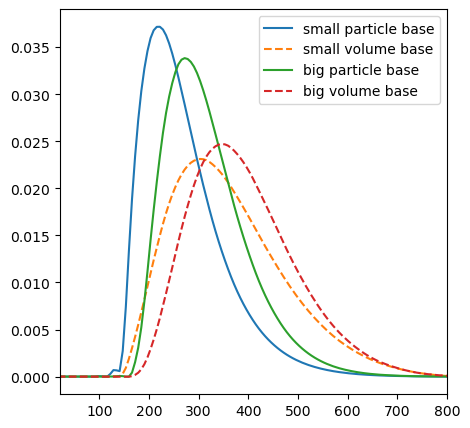

In [3]:
x_new = np.linspace(10, 1200, num=192, endpoint=True)

x_big = np.array(["0.010000","0.011298","0.012765","0.014422","0.016295","0.018410","0.020800","0.023500","0.026551","0.029998","0.033892","0.038292","0.043264","0.048880","0.055226","0.062396","0.070496","0.079648","0.089988","0.101671","0.114870","0.129783","0.146631","0.165667","0.187175","0.211474","0.238928","0.269947","0.304992","0.344587","0.389322","0.439865","0.496969","0.561487","0.634381","0.716738","0.809787","0.914916","1.033693","1.167889","1.319508","1.490810","1.684351","1.903018","2.150073","2.429201","2.744567","3.100874","3.503438","3.958263","4.472136","5.052721","5.708679","6.449795","7.287125","8.233159","9.302010","10.509622","11.874010","13.415526","15.157166","17.124910","19.348112","21.859937","24.697853","27.904195","31.526793","35.619687","40.243931","45.468507","51.371352","58.040520","65.575498","74.088687","83.707081","94.574161","106.852035","120.723855","136.396554","154.103924","174.110113","196.713559","222.251447","251.104732","283.703828","320.535028","362.147754","409.162757","462.281375","522.295996","590.101877","666.710502","753.264666","851.055526","961.541861","1086.371831","1227.407565","1386.752942","1566.784966","1770.189236","2000.000000"],dtype=np.float32)
y_big_cumul = np.array(["100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","99.967357","99.531262","97.665555","93.004685","84.284059","71.160269","54.783008","37.613600","22.428887","11.208570","4.418190","1.201278","0.137925","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000"],dtype=np.float32)
f_big_cumul = interp1d(x_big, y_big_cumul,kind='cubic')    
cumul_big = f_big_cumul(x_new)
PSD_bigv = -(cumul_big - np.roll(cumul_big,1))[1:192]
PSD_bigv = PSD_bigv/np.sum(PSD_bigv)
PSD_big= PSD_bigv/(np.arange(191)+1)**3
PSD_big = PSD_big/np.sum(PSD_big)/1
PSD_big[PSD_big<0] =0


x_small = np.array(["0.010000","0.011298","0.012765","0.014422","0.016295","0.018410","0.020800","0.023500","0.026551","0.029998","0.033892","0.038292","0.043264","0.048880","0.055226","0.062396","0.070496","0.079648","0.089988","0.101671","0.114870","0.129783","0.146631","0.165667","0.187175","0.211474","0.238928","0.269947","0.304992","0.344587","0.389322","0.439865","0.496969","0.561487","0.634381","0.716738","0.809787","0.914916","1.033693","1.167889","1.319508","1.490810","1.684351","1.903018","2.150073","2.429201","2.744567","3.100874","3.503438","3.958263","4.472136","5.052721","5.708679","6.449795","7.287125","8.233159","9.302010","10.509622","11.874010","13.415526","15.157166","17.124910","19.348112","21.859937","24.697853","27.904195","31.526793","35.619687","40.243931","45.468507","51.371352","58.040520","65.575498","74.088687","83.707081","94.574161","106.852035","120.723855","136.396554","154.103924","174.110113","196.713559","222.251447","251.104732","283.703828","320.535028","362.147754","409.162757","462.281375","522.295996","590.101877","666.710502","753.264666","851.055526","961.541861","1086.371831","1227.407565","1386.752942","1566.784966","1770.189236","2000.000000"],dtype=np.float32)
y_small_cumul = np.array(["100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","100.000000","99.987747","99.843016","98.774526","95.968438","90.624014","82.198548","70.793739","57.189275","42.769175","29.145927","17.709258","9.275982","3.923832","1.146321","0.118492","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000","0.000000"],dtype=np.float32)
# x_new_bra = np.linspace(20, 1800, num=192, endpoint=True)
f_small_cumul = interp1d(x_small, y_small_cumul,kind='cubic')    
cumul_small = f_small_cumul(x_new)
PSD_smallv = -(cumul_small - np.roll(cumul_small,1))[1:192]
PSD_smallv = PSD_smallv/np.sum(PSD_smallv)
# PSD_smallv[PSD_smallv<0]=0
PSD_small= PSD_smallv/(np.arange(191)+1)**3
PSD_small = PSD_small/np.sum(PSD_small)/1
PSD_small[PSD_small<0] =0

plt.figure(figsize=(5,5),facecolor='w')
plt.plot(x_new[1:],PSD_small,label='small particle base')
plt.plot(x_new[1:],PSD_smallv,'--',label='small volume base')
plt.plot(x_new[1:],PSD_big,label='big particle base')
plt.plot(x_new[1:],PSD_bigv,'--',label='big volume base')
# plt.plot(x_new[:],cumul_small,label='volume base')
plt.xlim(20,800)
plt.legend()

In [4]:

mean=[]
std=[]
time = []
auto = []
for idx in tqdm(range(100)):
    try:
        filename =  '20221126_pupil_KCl_Acetone_before/20221126_pupil_KCl_Acetone_before'+"_" + str(idx) + "_psd_curve_" + ".mat"
        matdata = loadmat(filename)
        time.append(matdata['time'])
        mean.append(np.mean(matdata['mean']))
        std.append(np.mean(matdata['std']))
        psd.append(matdata['PSD'])
        auto.append(matdata['auto'])
    except:
        break
auto = np.concatenate(np.array(auto))
# mean =np.array(mean)
# std = np.array(std)
time =  np.squeeze(np.array(time))



mean2=[]
std2=[]
time2 = []
auto2 = []
for idx in tqdm(range(500)):
    try:
        filename =  '20221126_pupil_KCl_Acetone_before/20221126_pupil_KCl_Acetone_before2'+"_" + str(idx) + "_psd_curve_" + ".mat"
        matdata = loadmat(filename)
        time2.append(matdata['time'])
        mean2.append(np.mean(matdata['mean']))
        std2.append(np.mean(matdata['std']))
        psd2.append(matdata['PSD'])
        auto2.append(matdata['auto'])
    except:
        break
    
auto2 = np.concatenate(np.array(auto2))
# mean2 = np.array(mean2)
# std2 = np.array(std2)
time2 =  np.squeeze(np.array(time2))



mean3=[]
std3=[]
time3 = []
auto3 = []
for idx in tqdm(range(235)):
    try:
        filename =  '20221126_pupil_KCl_Acetone_ing/20221126_pupil_KCl_Acetone_ing'+"_" + str(idx) + "_psd_curve_" + ".mat"
        matdata = loadmat(filename)
        time3.append(matdata['time'])
        mean3.append(np.mean(matdata['mean']))
        std3.append(np.mean(matdata['std']))
        psd3.append(matdata['PSD'])
        auto3.append(matdata['auto']) 
    except:
        break  
auto3 = np.concatenate(np.array(auto3))
# mean3 =  np.array(mean3) 
# std3 = np.array(std3)
time3 =  np.squeeze(np.array(time3))

mean4=[]
std4=[]
time4 = []
auto4 = []
for idx in tqdm(range(500)):
    try:
        filename =  '20221126_pupil_KCl_EtOH_water_ing/20221126_pupil_KCl_EtOH_ing'+"_" + str(idx) + "_psd_curve_" + ".mat"
        matdata = loadmat(filename)
        time4.append(matdata['time'])
        mean4.append(np.mean(matdata['mean']))
        std4.append(np.mean(matdata['std']))
        psd4.append(matdata['PSD'])
        auto4.append(matdata['auto'])
    except:
        break
    
auto4 = np.concatenate(np.array(auto4))
# mean4 = np.array(mean4)
# std4 = np.array(std4)
time4 =  np.squeeze(np.array(time4))

mean5=[]
std5=[]
time5 = []
auto5 = []
for idx in tqdm(range(500)):
    try:
        filename =  '20221126_pupil_KCl_EtOH_water_ing/20221126_pupil_KCl_EtOH_ing2'+"_" + str(idx) + "_psd_curve_" + ".mat"
        matdata = loadmat(filename)
        time5.append(matdata['time'])
        mean5.append(np.mean(matdata['mean']))
        std5.append(np.mean(matdata['std']))
        psd5.append(matdata['PSD'])
        auto5.append(matdata['auto'])
    except:
        break
auto5 = np.concatenate(np.array(auto5))
psd5 = np.concatenate(np.array(psd5))
time5 =  np.squeeze(np.array(time5))

auto_total_acetone = np.concatenate([auto2,auto3])

time_raw_acetone =  np.concatenate([np.array([0]),time2,time3+time2[-1]])
idx_raw_acetone  = np.arange(time_raw_acetone.shape[0])*100
ft = interp1d(idx_raw_acetone, time_raw_acetone,kind='cubic')  #the interpolation function
time_total_acetone = ft(np.arange(100*(time_raw_acetone.shape[0]-1)))



auto_total_EtOHw = np.concatenate([auto2,auto4,auto5])

time_raw_EtOHw =  np.concatenate([np.array([0]),time2,time4+time2[-1],time5+time2[-1]+time4[-1]])
idx_raw_EtOHw  = np.arange(time_raw_EtOHw.shape[0])*100
ft = interp1d(idx_raw_EtOHw, time_raw_EtOHw,kind='cubic')  #the interpolation function
time_total_EtOHw = ft(np.arange(100*(time_raw_EtOHw.shape[0]-1)))

print('auto_total_EtOHw: ',auto_total_EtOHw.shape)
print('time_total_EtOHw: ',time_total_EtOHw.shape)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

auto_total_acetone:  (700, 96, 96)
psd_acetone:  (700, 63)
time_acetone:  (700,)
auto_total_EtOHw:  (8100, 96, 96)


NameError: name 'psd_total_EtOHw' is not defined

In [5]:
#plot data for EtOHw
auto_exp_raw_t = torch.tensor(auto_total_EtOHw,dtype=torch.float32).cuda()
auto_exp_t = (torch.abs(auto_exp_raw_t-0.006)**0.25)*mask_t
auto_exp_t =auto_exp_t.reshape((auto_exp_t.shape[0],1,96,96))
new_cumul_predict_plot_r = np.zeros((auto_exp_t.shape[0],192//3))
new_cumul_predict_plot = np.zeros((auto_exp_t.shape[0],192))
new_pred_PSD_EtOHw= np.zeros((auto_exp_t.shape[0], new_cumul_predict_plot_r.shape[-1]-1))
new_pred_PSDv_EtOHw = np.zeros((auto_exp_t.shape[0], new_cumul_predict_plot_r.shape[-1]-1))

for i in tqdm(range(auto_exp_t.shape[0])):
    #predict cumulative distribution
    cumul_predict_plot = predictor(generator(auto_exp_t[i:i+1])).reshape(192).cpu().detach().numpy()
    cumul_predict_plot = normalize(cumul_predict_plot)#
    cumul_predict_plot_r = rebin1d(cumul_predict_plot,(64))

    #predict PSD    
    pred_PSD = -(cumul_predict_plot_r - np.roll(cumul_predict_plot_r,1))[1:64]
    pred_PSD = pred_PSD/np.sum(pred_PSD)/3
    # pred_PSD = np.abs(pred_PSD)
    pred_PSD[pred_PSD<0]=0
    new_pred_PSD_EtOHw[i] = pred_PSD
    
    #predict volume based PSD
    pred_PSDvolume = pred_PSD*(np.arange(63)+1)**3
    pred_PSDvolume= pred_PSDvolume/np.sum(pred_PSDvolume)/3
    # pred_PSD = np.abs(pred_PSD)
    pred_PSDvolume[pred_PSDvolume<0]=0
    new_pred_PSDv_EtOHw[i] = pred_PSDvolume


  0%|          | 0/8100 [00:00<?, ?it/s]

In [190]:
# new_pred_PSD_origin = new_pred_PSD

# Fig.S6

[None, None, None, None]

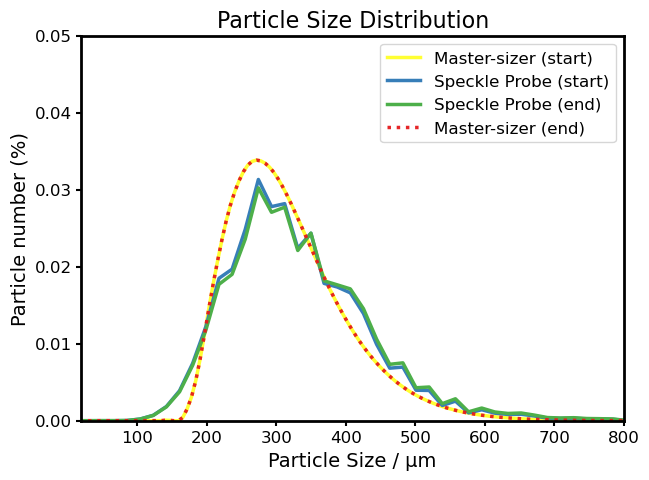

In [6]:
cmap = plt.get_cmap('Set1')
colors = cmap#[cmap(i) for i in np.linspace(0.25, 0.85, 196//2)]

x_plot = np.linspace(10,1200,64,endpoint=True)
plt.figure(figsize=(7,5),facecolor='w')
plt.plot(x_new[1:],PSD_big,'-',color=cmap(5) ,label='Master-sizer (start)',linewidth=2.5,alpha=1)
# plt.plot( x_plot[:-1], np.mean(new_pred_PSD_origin[0:100],axis=0) ,color=colors(1) ,linewidth=2,alpha=1,label='0.5 min (start)')
# plt.plot( x_plot[:-1], np.mean(new_pred_PSD_origin[-100:],axis=0) ,color=colors(2) ,linewidth=2,alpha=1,label='-0.5 min (end)')
# plt.plot( x_plot[:-1], new_pred_PSD[3] ,color=colors(3) ,linewidth=2,alpha=1,label='0.5 min (start)')
plt.plot( x_plot[:-1], np.mean(new_pred_PSD_EtOHw[0:100],axis=0) ,'-',color=colors(1) ,linewidth=2.5,alpha=1,label='Speckle Probe (start)')
plt.plot( x_plot[:-1], np.mean(new_pred_PSD_EtOHw[-100:],axis=0) ,'-',color=colors(2) ,linewidth=2.5,alpha=1,label='Speckle Probe (end)')
# plt.plot( x_plot[:-1], psd_total_EtOHw[3] ,'--',color=colors(6) ,linewidth=2,alpha=1,label='0.5 min (start)')

plt.plot(x_new[1:],PSD_big,':',color=colors(0) ,label='Master-sizer (end)',linewidth=2.5,alpha=0.95)

plt.xlim(20,800)
plt.ylim(0,0.05)
plt.xlabel('Size / um')
plt.ylabel('Particle Size Distribution')
plt.legend(fontsize=12)

plt.gca().yaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=14)
plt.gca().set_ylabel('Particle number (%)',fontsize=14)
plt.title('Particle Size Distribution',fontsize=16)
[x.set_linewidth(2) for x in plt.gca().spines.values()]


In [8]:
psd_max = np.zeros(new_pred_PSD_EtOHw.shape[0])
print(psd_max.shape)

for i in range(new_pred_PSD_EtOHw.shape[0]):
    psd_max[i] = np.argmax(new_pred_PSD_EtOHw[i]) 

psd_max = psd_max/63*1200

time_total_filter = []
psd_total_filter = []
for i in range(new_pred_PSD_EtOHw.shape[0]):
    if psd_max[i]>85:
        time_total_filter.append(time_total_EtOHw[i])
        psd_total_filter.append(new_pred_PSD_EtOHw[i])
    
time_total_filter = np.array(time_total_filter)
psd_total_filter = np.array(psd_total_filter)

print(psd_total_filter.shape)

xx = np.linspace(20,1200,63)
size_max_EtOHw = xx[np.argmax(psd_total_filter,axis=-1)]
print(size_max_EtOHw.shape)

(8100,)
(7512, 63)
(7512,)


# Fig.5a

In [9]:
psd_total_filter_rebin = rebin(psd_total_filter[:7200],(7200//8,63))
time_total_filter_rebin = rebin1d(time_total_filter[:7200],(7200//8))


(900,)


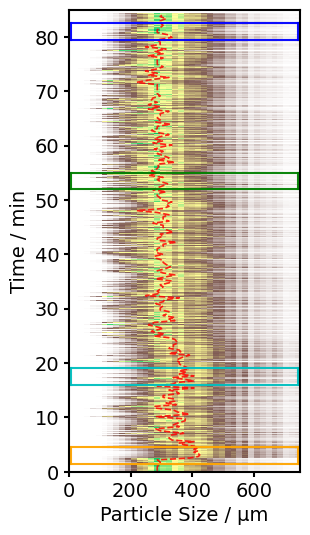

In [21]:
tt = time_total_filter_rebin#EtOHw
xx = np.linspace(20,1200,63)

TT, XX = np.meshgrid(tt,xx)
size_max_EtOHw_rebin = xx[np.argmax(psd_total_filter_rebin,axis=-1)]
print(size_max_EtOHw_rebin.shape)
fig = plt.figure(figsize=(6,6),facecolor='w')
plt.pcolormesh(XX,TT,psd_total_filter_rebin.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_EtOHw_rebin,900//4),rebin1d(tt,900//4),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.rainbow_r)
#blue 79.5-82.5
plt.axhline(y=79.5, color='blue', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axhline(y=82.5, color='blue', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=5,ymin=79.5/85,ymax=82.5/85, color='blue', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=750-5,ymin=79.5/85,ymax=82.5/85, color='blue', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
#red 1.5-4.5
plt.axhline(y=1.5, color='orange', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axhline(y=4.5, color='orange', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=5,ymin=1.5/85,ymax=4.5/85, color='orange', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=750-5,ymin=1.5/85,ymax=4.5/85, color='orange', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
#red 52-55
plt.axhline(y=52, color='green', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axhline(y=55, color='green', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=5,ymin=52/85,ymax=55/85, color='green', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=750-5,ymin=52/85,ymax=55/85, color='green', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
#orange 16-19
plt.axhline(y=16, color='c', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axhline(y=19, color='c', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=5,ymin=16/85,ymax=19/85, color='c', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)
plt.axvline(x=750-5,ymin=16/85,ymax=19/85, color='c', linestyle='-',label= 'line1',linewidth=1.5,alpha=0.95)

# plt.legend()

plt.gca().set_aspect(750/85*2)
plt.ylim(0,85)
plt.xlim(20,750)
plt.xticks([0,200,400,600])

# plt.gca().set_aspect(900/2*2)
# plt.ylim(30,32)
# plt.yticks([0,10,20,30,40,50,60,70,80])

# plt.clim(0,0.045)
plt.clim(0,0.046)

plt.gca().yaxis.set_tick_params(labelsize=14,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=14,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=14)
plt.gca().set_ylabel('Time / min',fontsize=14)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]

# clb = plt.colorbar()
# clb.ax.set_title('Size Distribution',fontsize=14)
# clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
# [x.set_linewidth(1.5) for x in clb.ax.spines.values()]


fig.savefig('../figures/fig_5a_1.tiff', dpi=350, format=None)

# Fig.5b

(7512,)


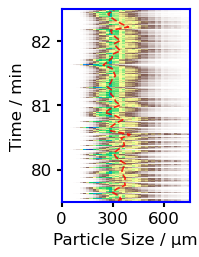

In [22]:
tt = time_total_filter#EtOHw
xx = np.linspace(20,1200,63)

TT, XX = np.meshgrid(tt,xx)
print(size_max_EtOHw.shape)
fig = plt.figure(figsize=(2.5,2.5),facecolor='w')
plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_EtOHw[0:7500],7500//4),rebin1d(tt[0:7500],7500//4),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.rainbow_r)
# plt.axhline(y=0.5, color='r', linestyle='--',label= 'line1',linewidth=1,alpha=0.95)
# plt.legend()

plt.gca().set_aspect(750/3*1.5)
plt.ylim(79.5,82.5)
plt.xlim(0,750)
plt.xticks([0,300,600])

# plt.gca().set_aspect(900/2*2)
# plt.ylim(30,32)
# plt.yticks([0,10,20,30,40,50,60,70,80])

# plt.clim(0,0.055)
plt.clim(0,0.046)
plt.gca().yaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=12)
plt.gca().set_ylabel('Time / min',fontsize=12)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]
[x.set_color('blue') for x in  plt.gca().spines.values()]

# clb = plt.colorbar()
# clb.ax.set_title('Size Distribution',fontsize=14)
# clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
# [x.set_linewidth(1.5) for x in clb.ax.spines.values()]
fig.savefig('../figures/fig_5b_4.tiff', dpi=350, format=None)

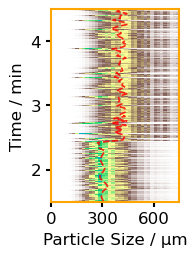

In [23]:
tt = time_total_filter#EtOHw
xx = np.linspace(20,1200,63)

TT, XX = np.meshgrid(tt,xx)

fig = plt.figure(figsize=(2.5,2.5),facecolor='w')
plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_EtOHw[0:7500],7500//4),rebin1d(tt[0:7500],7500//4),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.rainbow_r)
# plt.axhline(y=0.5, color='r', linestyle='--',label= 'line1',linewidth=1,alpha=0.95)
# plt.legend()

plt.gca().set_aspect(750/3*1.5)
plt.ylim(1.5,4.5)
plt.xlim(0,750)
plt.xticks([0,300,600])

# plt.gca().set_aspect(900/2*2)
# plt.ylim(30,32)
# plt.yticks([0,10,20,30,40,50,60,70,80])

plt.clim(0,0.046)
plt.gca().yaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=12)
plt.gca().set_ylabel('Time / min',fontsize=12)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]
[x.set_color('orange') for x in  plt.gca().spines.values()]

# clb = plt.colorbar()
# clb.ax.set_title('Size Distribution',fontsize=14)
# clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
# [x.set_linewidth(1.5) for x in clb.ax.spines.values()]
fig.savefig('../figures/fig_5b_1.tiff', dpi=350, format=None)

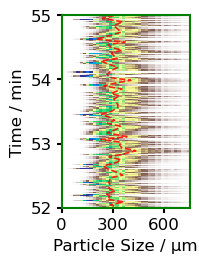

In [24]:
tt = time_total_filter#EtOHw
xx = np.linspace(20,1200,63)

TT, XX = np.meshgrid(tt,xx)

fig = plt.figure(figsize=(2.5,2.5),facecolor='w')
plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_EtOHw[0:7500],7500//4),rebin1d(tt[0:7500],7500//4),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.rainbow_r)
# plt.axhline(y=0.5, color='r', linestyle='--',label= 'line1',linewidth=1,alpha=0.95)
# plt.legend()

plt.gca().set_aspect(750/3*1.5)
plt.ylim(52,55)
plt.xlim(20,750)
plt.xticks([0,300,600])

# plt.gca().set_aspect(900/2*2)
# plt.ylim(30,32)
# plt.yticks([0,10,20,30,40,50,60,70,80])

plt.clim(0,0.046)
plt.gca().yaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=12)
plt.gca().set_ylabel('Time / min',fontsize=12)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]
[x.set_color('green') for x in  plt.gca().spines.values()]

# clb = plt.colorbar()
# clb.ax.set_title('Size Distribution',fontsize=14)
# clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
# [x.set_linewidth(1.5) for x in clb.ax.spines.values()]
fig.savefig('../figures/fig_5b_3.tiff', dpi=350, format=None)

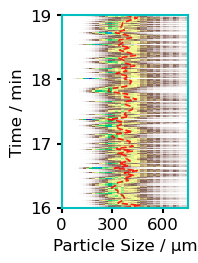

In [25]:
tt = time_total_filter#EtOHw
xx = np.linspace(20,1200,63)

TT, XX = np.meshgrid(tt,xx)

fig = plt.figure(figsize=(2.5,2.5),facecolor='w')
plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_EtOHw[0:7500],7500//4),rebin1d(tt[0:7500],7500//4),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_filter.T, shading='nearest' ,cmap=plt.cm.rainbow_r)
# plt.axhline(y=0.5, color='r', linestyle='--',label= 'line1',linewidth=1,alpha=0.95)
# plt.legend()

plt.gca().set_aspect(760/3*1.5)
plt.ylim(16,19)
plt.xlim(0,750)
plt.xticks([0,300,600])

# plt.gca().set_aspect(900/2*2)
# plt.ylim(30,32)
# plt.yticks([0,10,20,30,40,50,60,70,80])

plt.clim(0,0.046)
plt.gca().yaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=12,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=12)
plt.gca().set_ylabel('Time / min',fontsize=12)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]
[x.set_color('c') for x in  plt.gca().spines.values()]

# clb = plt.colorbar()
# clb.ax.set_title('Size Distribution',fontsize=14)
# clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
# [x.set_linewidth(1.5) for x in clb.ax.spines.values()]
fig.savefig('../figures/fig_5b_2.tiff', dpi=350, format=None)

# Fig.5c

In [16]:
#plot data for acetone
auto_exp_raw_t = torch.tensor(auto_total_acetone,dtype=torch.float32).cuda()
auto_exp_t = (torch.abs(auto_exp_raw_t-0.006)**0.25)*mask_t
auto_exp_t =auto_exp_t.reshape((auto_exp_t.shape[0],1,96,96))

new_cumul_predict_plot_r = np.zeros((auto_exp_t.shape[0],192//3))
new_cumul_predict_plot = np.zeros((auto_exp_t.shape[0],192))
new_pred_PSD_acetone= np.zeros((auto_exp_t.shape[0], new_cumul_predict_plot_r.shape[-1]-1))
new_pred_PSDv_acetone = np.zeros((auto_exp_t.shape[0], new_cumul_predict_plot_r.shape[-1]-1))

for i in tqdm(range(auto_exp_t.shape[0])):
    #predict cumulative distribution
    cumul_predict_plot = predictor(generator(auto_exp_t[i:i+1])).reshape(192).cpu().detach().numpy()
    cumul_predict_plot = normalize(cumul_predict_plot)#
    cumul_predict_plot_r = rebin1d(cumul_predict_plot,(64))

    #predict PSD    
    pred_PSD = -(cumul_predict_plot_r - np.roll(cumul_predict_plot_r,1))[1:64]
    pred_PSD = pred_PSD/np.sum(pred_PSD)/3
    # pred_PSD = np.abs(pred_PSD)
    pred_PSD[pred_PSD<0]=0
    new_pred_PSD_acetone[i] = pred_PSD
    
    #predict volume based PSD
    pred_PSDvolume = pred_PSD*(np.arange(63)+1)**3
    pred_PSDvolume= pred_PSDvolume/np.sum(pred_PSDvolume)/3
    # pred_PSD = np.abs(pred_PSD)
    pred_PSDvolume[pred_PSDvolume<0]=0
    new_pred_PSDv_acetone[i] = pred_PSDvolume


  0%|          | 0/700 [00:00<?, ?it/s]

(700, 63)
(700,)


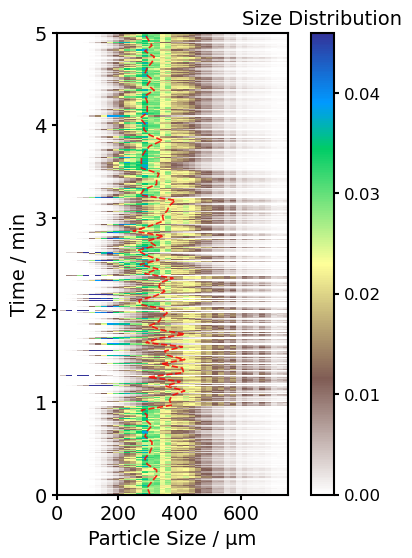

In [26]:
##### calculate mean size


tt = time_total_acetone-1.5
xx = np.linspace(20,1200,63)
print(new_pred_PSD_acetone.shape)
# size_mean_acetone = np.sum(new_pred_PSD_acetone*xx,axis=-1)#/np.sum(new_pred_PSD_acetone,axis=-1)
# print(size_mean_acetone.shape)
size_max_acetone = xx[np.argmax(new_pred_PSD_acetone,axis=-1)]
print(size_max_acetone.shape)

TT, XX = np.meshgrid(tt,xx)
        
fig = plt.figure(figsize=(6,6),facecolor='w')
plt.pcolormesh(XX,TT,new_pred_PSD_acetone.T, shading='nearest' ,cmap=plt.cm.terrain_r)
plt.plot(rebin1d(size_max_acetone,700//5),rebin1d(tt,700//5),'r--',alpha=0.85,linewidth=1.2)

# plt.pcolormesh(XX,TT,psd_total_acetone.T, shading='nearest' ,cmap=plt.cm.terrain_r)
# plt.pcolormesh(psd_total_acetone.T, shading='nearest' ,cmap=plt.cm.terrain_r)
# plt.axhline(y=0.5, color='r', linestyle='--',label= 'line1',linewidth=1,alpha=0.95)
# plt.legend()

plt.gca().set_aspect(750/5*2)
plt.ylim(0,5)
plt.xlim(0,750)
plt.clim(0,0.046)
plt.xticks([0,200,400,600])


# plt.gca().set_aspect(900/2*2)
# plt.ylim(3,5)
# plt.yticks([0,10,20,30,40,50,60,70,80])
plt.gca().yaxis.set_tick_params(labelsize=14,width=1.5)
plt.gca().xaxis.set_tick_params(labelsize=14,width=1.5)
plt.gca().set_xlabel('Particle Size / μm',fontsize=14)
plt.gca().set_ylabel('Time / min',fontsize=14)
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]

clb = plt.colorbar()
clb.ax.set_title('Size Distribution',fontsize=14)
clb.ax.tick_params(labelsize=12,width=1.5)
# clb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
[x.set_linewidth(1.5) for x in clb.ax.spines.values()]
fig.savefig('../figures/fig_5c.tiff', dpi=350, format=None)

In [22]:
# import pandas as pd

# m_begin = pd.DataFrame ({"size/um":x_new[1:], "percentage":PSD_big}, columns = ["size/um", "percentage"] )
# filepath = 'Master sizer begin.xlsx'
# m_begin.to_excel(filepath, index=False)

# m_end = pd.DataFrame ({"size/um":x_new[1:], "percentage":PSD_small}, columns = ["size/um", "percentage"] )
# filepath = 'Master sizer end.xlsx'
# m_end.to_excel(filepath, index=False)

# s_begin = pd.DataFrame ({"size/um":x_plot[:-1], "percentage":psd_total[7]}, columns = ["size/um", "percentage"] )
# filepath = 'speckle probe begin.xlsx'
# s_begin.to_excel(filepath, index=False)

# s_26 = pd.DataFrame ({"size/um":x_plot[:-1], "percentage":psd_total[70]}, columns = ["size/um", "percentage"] )
# filepath = 'speckle probe 26min.xlsx'
# s_26.to_excel(filepath, index=False)

# s_59 = pd.DataFrame ({"size/um":x_plot[:-1], "percentage":psd_total[174]}, columns = ["size/um", "percentage"] )
# filepath = 'speckle probe 59min.xlsx'
# s_59.to_excel(filepath, index=False)

# s_end = pd.DataFrame ({"size/um":x_plot[:-1], "percentage":psd_total[232]}, columns = ["size/um", "percentage"] )
# filepath = 'speckle probe end.xlsx'
# s_end.to_excel(filepath, index=False)